## Whole Foods 'ON SALE' and 'PRIME DISCOUNT' Data
### This data is scraped from Whole Foods Featured On Sale Web Page
#### This jupyter notebook cleans, aggregates, and creates new features to show insights of many different details of Whole Foods 'On Sale Items' such as:

    - items with the highest prime discounts
    - items with the highest prime discounts by company
    - difference between sales discounts and prime discounts (Shows how much of a bigger discount prime members receive than normal shoppers)

In [1]:
import os, random, sys, time 
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd

In [9]:
browser = webdriver.Chrome('C:/Users/Water/Desktop/chromedriver.exe') # Chrome Driver
browser.get('https://www.wholefoodsmarket.com/products/all-products?featured=on-sale') # Website Link
browser.find_element_by_xpath("//input[@id='pie-store-finder-modal-search-field']").send_keys('19073') # Zip code
time.sleep(2) # lag for 2 seconds to allow elements to load
browser.find_element_by_xpath("//span[contains(text(),'Newtown - 3737 West Chester Pike, Newtown Square, PA 19073')]").click() # needs optimization

In [10]:
#---------------------
# Continously loads all possible product data until no more data exists
# Sometimes may take some time if there are many products on sale
try:
    load = browser.find_element_by_xpath("//span[contains(text(),'Load more')]") 
    while True:
        load.click()
        time.sleep(2) # Must have a 2 sec time lag so the 'load more' button can reappear
except:
    print("Results Filled") # If all possible data is populated

Results Filled


------------------------

In [11]:
all_items = browser.find_elements_by_xpath("//div[@data-testid='product-tile']") # Pull all product elements by xpath
list_of_items = [items.text.splitlines() for items in all_items] # Create a list comprehension of all product elements with text shown and lines split

In [139]:
#import pickle
#with open('list_of_items.pkl', 'wb') as handle:
#    pickle.dump(list_of_items, handle, protocol=pickle.HIGHEST_PROTOCOL) # Save list_of_items to a .pkl so we dont have to rescrape and load in the future
#
# 
#with open('list_of_items.pkl', 'rb') as handle: # loads our saved .pkl back into a variable
#    test = pickle.load(handle)

True

---------------

In [334]:
d = {"company":[], "product":[], "regular":[], "sale":[], "prime":[]} # Create a Dict

In [335]:
for i in range(len(all_items)):                        # At the range of the length of all items (will loop i times)
        d["company"].append(list_of_items[i][-5])      # Append respective indexed data in list_of_items[i] for each column
        d["product"].append(list_of_items[i][-4])      # | -
        d["regular"].append(list_of_items[i][-3][8:])  # | * 
        d["sale"].append(list_of_items[i][-2][10:])    # | /
        d["prime"].append(list_of_items[i][-1][18:])   # | \
print(len(d["company"]))                               # Verify that the length of each column is == to each other, otherwise the dataframe wont be populated 
print(len(d["product"]))                               # | - 
print(len(d["regular"]))                               # | *
print(len(d["sale"]))                                  # | /
pd.set_option("display.max_rows", 500)                 # | \ Change Pandas option to view more rows of the df
df = pd.DataFrame.from_dict(d)                         # Turn our Dict to a Pandas DataFrame  

2075
2075
2075
2075


In [336]:
# BAKERY is not a product name, WholeFoods sometimes lists the origin as the product name since it is made in house
# Because of this we will grab the indices where this is True and remove all rows that pertain to these indices
# We will then create a new dictionary and re-append all items again with shifted index values to properly fit each KEY and Value (Ex. Bakery goes under Company in this case)
# We will then set this new dict as df2, and reinstantiate df2 as df2 where 'BAKERY' only exists 
# Finally we concat the df where we dropped the rows, and the new df2 that has our new 'BAKERY' rows
if any(list(df['product'].str.contains('BAKERY'))):        
    ix = df[df['product'].str.contains('BAKERY')].index
    df = df.drop(list(ix))
    a = {"company":[], "product":[], "regular":[], "sale":[], "prime":[]}
    for i in range(len(all_items)):                        
        a["company"].append(list_of_items[i][-4])
        a["product"].append(list_of_items[i][-3])
        a["regular"].append(list_of_items[i][-2][8:])
        a["sale"].append(list_of_items[i][-2][8:])
        a["prime"].append(list_of_items[i][-1][19:])
    df2 = pd.DataFrame.from_dict(a)
    df2 = df2[df2['company'].str.contains('BAKERY')]
    df = pd.concat([df,df2]).sort_index()
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------    
# We then sort by index and remove all '$' and '/lb' symbols from each column to prepare the data for numerical values
df = df.sort_index()  
df['sale'] = df['sale'].str.replace(r'$', '')
df['prime'] = df['prime'].str.replace(r'$', '')
df['regular'] = df['regular'].str.replace(r'$', '')
df['sale'] = df['sale'].str.rstrip('  /lb')
df['prime'] = df['prime'].str.rstrip('  /lb')
df['regular'] = df['regular'].str.rstrip('  /lb')

C:\Users\water\AppData\Local\Temp/ipykernel_27196/887583663.py:22: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\water\AppData\Local\Temp/ipykernel_27196/887583663.py:23: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\water\AppData\Local\Temp/ipykernel_27196/887583663.py:24: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



----------------------------------

#### Code used for debugging to see values in the 'Company' Column that have the VALID THROUGH caption instead of Company Name

In [852]:
#df[df['company'].str.contains('/')].sort_values(by='product') # Used for Debugging to see values in the 'Company' Column that have the VALID THROUGH Date caption instead of Company Name

#### Sample Code to fetch indicies of rows where a specific str exists in a DataFrame and Loop any potential edits


In [709]:
#if any(list(df['company'].str.contains('/'))):                         
#    ix = df[df['company'].str.contains('/')].index
#    for i in range(len(ix)):
#        df.loc[ix[i],'company'] = df.loc[ix[i], 'product'] 

----------------------------

#### Continued data cleaning of companies and products in the wrong sections since Whole Foods has some products without a company name or without a sale price (ex. Prime Only Discounts)

In [337]:
# Data cleaning/shifting for products by Brita
if any(list(df['company'].str.contains('/'))) and any(list(df['product'].str.contains('Brita'))):
    ix = df[df['company'].str.contains('/')][df['product'].str.contains('Brita')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

C:\Users\water\AppData\Local\Temp/ipykernel_27196/1154484415.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [338]:
# Data cleaning/shifting for products
if any(list(df['product'].str.contains("Easy Peel White Shrimp 8-12 Count"))):
    ix = df[df['product'].str.contains("Easy Peel White Shrimp 8-12 Count")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Whole Foods Market"
if any(list(df['product'].str.contains("Organic Freeze Dried Chives, 0.14 oz"))):
    ix = df[df['product'].str.contains("Organic Freeze Dried Chives, 0.14 oz")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Green Garden"
if any(list(df['product'].str.contains("Organic Freeze Dried Thyme, 0.26 oz"))):
    ix = df[df['product'].str.contains("Organic Freeze Dried Thyme, 0.26 oz")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Green Garden"
if any(list(df['product'].str.contains("Organic Mild Plant Taco Meatless Crumbles"))):
    ix = df[df['product'].str.contains("Organic Mild Plant Taco Meatless Crumbles")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "PLANT BOSS"
if any(list(df['product'].str.contains("Organic Multicolor Kale"))):
    ix = df[df['product'].str.contains("Organic Multicolor Kale")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Whole Foods Market"        

In [339]:
# Data cleaning/shifting for products by Soozy's
if any(list(df['product'].str.contains("Soozy's Birthday Cake Cookies"))):
    ix = df[df['product'].str.contains("Soozy's Birthday Cake Cookies")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Soozy's"
if any(list(df['product'].str.contains("Soozys Chocolate Chip Cookies"))):
    ix = df[df['product'].str.contains("Soozys Chocolate Chip Cookies")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Soozy's"

In [340]:
# Data cleaning/shifting for products by Whole Foods Market
if any(list(df['product'].str.contains('Whole Foods Market'))):
    ix = df[df['product'].str.contains('Whole Foods Market')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df['sale'] = df['sale'].str.rstrip('  /lb')
        df['prime'] = df['prime'].str.rstrip('  /lb')
        df['regular'] = df['regular'].str.rstrip('  /lb')
        df.loc[ix[i], 'sale'] = 0

In [341]:
# Data cleaning/shifting for products by CAMELBAK
if any(list(df['product'].str.contains('CAMELBAK'))):
    ix = df[df['product'].str.contains('CAMELBAK')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [342]:
# Data cleaning/shifting for products by NEW WAVE
if any(list(df['product'].str.contains('NEW WAVE'))):
    ix = df[df['product'].str.contains('NEW WAVE')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [343]:
# Data cleaning/shifting for products by Enviro
if any(list(df['product'].str.contains('Enviro'))):
    ix = df[df['product'].str.contains('Enviro')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [344]:
# Data cleaning/shifting for products by HYDRO FLASK
if any(list(df['product'].str.contains('HYDRO FLASK'))):
    ix = df[df['product'].str.contains('HYDRO FLASK')].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i],'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [345]:
# Data cleaning/shifting for products by SUNDESA
if any(list(df['product'].str.contains('SUNDESA'))):
    ix = df[df['product'].str.contains('SUNDESA')].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i],'product'] = df.loc[ix[i], 'regular']
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [346]:
if any(list(df['product'].str.contains('Lemonade Electrolyte Powder Packet, 0.12 oz'))):
    ix = df[df['product'].str.contains('Lemonade Electrolyte Powder Packet, 0.12 oz')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-3][7:]
if any(list(df['product'].str.contains('Wild Raspberry Electrolyte Powder Packet, 0.11 oz'))):
    ix = df[df['product'].str.contains('Wild Raspberry Electrolyte Powder Packet, 0.11 oz')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-3][7:]
if any(list(df['product'].str.contains('Orange Pkt, 0.3 oz'))):
    ix = df[df['product'].str.contains('Orange Pkt, 0.3 oz')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-3][7:]

In [347]:
d = df.to_dict('list') # Take our cleaned dataframe and convert it to a dictionary for more cleaning

#### The following code replaces strings such as '2 for 5', splits them '2' 'for' '5', and divides position[2] by position[0] '5'/'2' while casting them as float values
#### this way we can understand the unit price per item for such deals, in this example '2 for 5' is 2.50

In [348]:
for i in range(len(d['sale'])):                                                
    if isinstance(d['sale'][i], str) and 'for' in d['sale'][i].split():  
        d['sale'][i] = float(d['sale'][i].split()[2]) / float(d['sale'][i].split()[0])

In [349]:
for i in range(len(d['prime'])):                                                
        if isinstance(d['prime'][i], str) and 'for' in d['prime'][i].split():  
            d['prime'][i] = float(d['prime'][i].split()[2]) / float(d['prime'][i].split()[0])

In [380]:
df = pd.DataFrame.from_dict(d) # turn our dict back into a dataframe


In [381]:
df.to_csv('testing.csv')

In [382]:
df = df.fillna(0) # Sometimes NaN Values are created in Sale Price since there is no Sale Price, We also instantiate 0's here originally when there are no Sale Prices
                  # Some aggregate functions create NaN's again, so we replace them again with 0
df.isna().any()   # We check to see if there are any NaN values

company    False
product    False
regular    False
sale       False
prime      False
dtype: bool

-----------------

In [383]:
for i in range(len(df[df['sale'].str.contains('¢', na=False)].index)): # Append a '.' to all values that have a cents symbol
    ix = df[df['sale'].str.contains('¢', na=False)].index
    df.loc[ix[i]][3] = '.' + df.loc[ix[i]][3]

In [384]:
for i in range(len(ix)):
    ix = df[df['prime'].str.contains('¢', na=False)].index
    df.loc[ix[i]][4] = '.' + df.loc[ix[i]][4]

In [385]:
try:
    for i in range(len(ix)):
        ix = df[df['regular'].str.contains('¢', na=False)].index
        df.loc[ix[i]][2] = '.' + df.loc[ix[i]][2]
except:
    pass

In [386]:
ix = df[df['prime'].str.contains('¢', na=False)].index
for i in range(len(ix)):
    df.loc[ix[i]][4] = df.loc[ix[i]][4].replace('¢', '')

ix = df[df['regular'].str.contains('¢', na=False)].index
for i in range(len(ix)):
    df.loc[ix[i]][2] = df.loc[ix[i]][2].replace('¢', '')

ix = df[df['sale'].str.contains('¢', na=False)].index
for i in range(len(ix)):
    df.loc[ix[i]][3] = df.loc[ix[i]][3].replace('¢', '')


In [388]:
df['sale']=df['sale'].replace('¢', '') # Strip the cents symbol afterwords
df['prime']=df['prime'].replace('¢', '')
df['regular']=df['regular'].replace('¢', '')


In [390]:
df["regular"] = pd.to_numeric(df["regular"]) # change columns to numeric for visualization
df["sale"] = pd.to_numeric(df["sale"])
df["prime"] = pd.to_numeric(df["prime"])

In [391]:
df['sale_discount'] = 1-df['sale']/df['regular'] # create new feature to show percentage discount of sale price
df['prime_discount'] = 1-df['prime']/df['regular'] # create new feature to show percentage discount of prime price

In [392]:
df['prime_sale_difference'] = df['prime_discount'] - df['sale_discount'] # create new feature to show the difference between sale discount and prime discount

In [393]:
df['discount_bins'] = pd.cut(df.prime_discount, [0,.25,.50,.75, 1], labels=['0% to 25%', '25% to 50%', '50% to 75%', '75% or more'])

In [394]:
df = df.sort_values(by='prime_discount', ascending=False) # sort by difference

In [395]:
df

,company,product,regular,sale,prime,sale_discount,prime_discount,prime_sale_difference,discount_bins
1188,Simply Organic,"Organic Ground Black Pepper, 4 oz",5.99,0.89,0.80,0.851419,0.866444,0.015025,75% or more
1778,Brekki,Overnight Oats With Ancient Grains Buleberries...,2.99,0.99,0.89,0.668896,0.702341,0.033445,50% to 75%
1690,Brekki,"Original Overnight Oats, 5.3 oz",2.99,0.99,0.89,0.668896,0.702341,0.033445,50% to 75%
1770,Brekki,"Banana And Maple Brown Sugar Overnight Oats, 5...",2.99,0.99,0.89,0.668896,0.702341,0.033445,50% to 75%
1938,Brekki,"Strawberry Overnight Oats, 5.3 oz",2.99,0.99,0.89,0.668896,0.702341,0.033445,50% to 75%
...,...,...,...,...,...,...,...,...,...
1081,Navitas Organics,"Organic Hemp Seeds, 8 Oz",10.79,10.49,9.44,0.027804,0.125116,0.097312,0% to 25%
454,Lakewood,"PURE Prune Organic, 32 fl oz",7.69,7.49,6.74,0.026008,0.123537,0.097529,0% to 25%
270,Lakewood,"Pure Tart Cherry Juice, 32 fl oz",7.69,7.49,6.74,0.026008,0.123537,0.097529,0% to 25%
1843,AURA CACIA,"Vetiver Essential Oil, 0.5 fl oz",19.99,19.49,17.54,0.025013,0.122561,0.097549,0% to 25%


In [363]:
df.head(500) # check

,company,product,regular,sale,prime
0,PRODUCE,Organic Bunched Celery,2.69,2.0,1.8
1,Vital Farms,"Pasture-raised Alfresco Eggs, 24 oz",5.99,5.49,4.94
2,Organic Valley,"Organic Large Brown Eggs, 24 oz",4.99,4.49,4.04
3,PRODUCE,Organic Tomato On The Vine,2.99,2.49,2.24
4,Beyond Meat,Beyond Burger,4.99,4.79,4.31
5,PRODUCE,Organic Green Kale,2.29,1.666667,1.5
6,Vital Proteins,"Unflavored Collagen Peptides, 20 oz",43.99,37.49,33.74
7,Siete Family Foods,"Almond Flour Amazing Grain Free Tortillas, 7 oz",8.29,6.99,6.29
8,PRODUCE,Organic Ginger Root,3.99,2.99,2.69
9,Whole Foods Market,Easy Peel White Shrimp 8-12 Count,19.99,15.99,14.39


In [297]:
df.to_csv('WholeFoods_Bakery_Data_Cleaned.CSV')

In [292]:
df

,company,product,regular,sale,prime,sale_discount,prime_discount,prime_sale_difference,discount_bins
10,Beyond Meat,Beyond Beef Plant-based Ground Beef,8.99,8.79,7.91,0.022247,0.120133,0.097887,0% to 25%
1843,AURA CACIA,"Vetiver Essential Oil, 0.5 fl oz",19.99,19.49,17.54,0.025013,0.122561,0.097549,0% to 25%
454,Lakewood,"PURE Prune Organic, 32 fl oz",7.69,7.49,6.74,0.026008,0.123537,0.097529,0% to 25%
270,Lakewood,"Pure Tart Cherry Juice, 32 fl oz",7.69,7.49,6.74,0.026008,0.123537,0.097529,0% to 25%
1140,HENRY & LISAS,"Wild Sardines In Spring Water, 4.25 oz",3.49,3.39,3.05,0.028653,0.126074,0.097421,0% to 25%
...,...,...,...,...,...,...,...,...,...
993,HYDRO FLASK,Black 32 Oz Wide Mouth Bottle With Flex Cap,44.95,0.00,31.46,1.000000,0.300111,-0.699889,25% to 50%
2055,HYDRO FLASK,40 Oz Wide Mouth With Flex Cap White 2.0,49.95,0.00,34.96,1.000000,0.300100,-0.699900,25% to 50%
1876,Brita,Filter Cartridge Replacement 3Pk,29.99,0.00,20.99,1.000000,0.300100,-0.699900,25% to 50%
1904,Brita,"Marina Filtering Bottle, 32 oz",39.99,0.00,27.99,1.000000,0.300075,-0.699925,25% to 50%


---------------------------

## Exploratory Data Analysis: <br/>
#### Histogram of all numerical feature distributions
##### we can see that 'prime_sale_difference' has a large outlier since we have sale price set to 0 for some items that don't have a sale price


array([[<AxesSubplot:title={'center':'regular'}>,
        <AxesSubplot:title={'center':'sale'}>],
       [<AxesSubplot:title={'center':'prime'}>,
        <AxesSubplot:title={'center':'sale_discount'}>],
       [<AxesSubplot:title={'center':'prime_discount'}>,
        <AxesSubplot:title={'center':'prime_sale_difference'}>]],
      dtype=object)

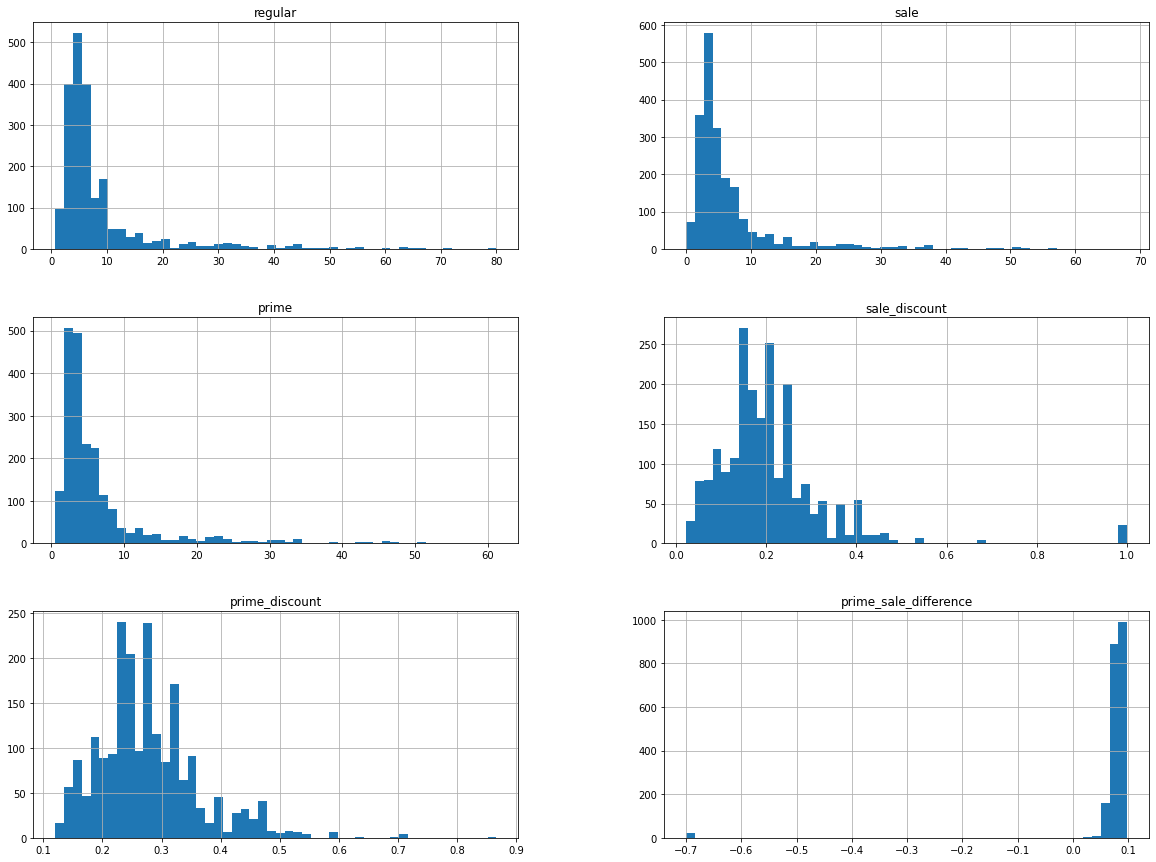

In [7]:
df.hist(bins=50, figsize=(20,15)) 

### These are distributions of all items that do not have a sale price listed
#### We can see that there are not that many items that don't have a sale price
##### Not having a sale price is defined as only having a 'regular price' and 'prime price'
##### These distributions show the items are ONLY discounted for prime members
      - only 23 out of 2075 products which is not many (1%)
      - this shows that over 99% of items on sale are discounted for regular customers and prime customers

In [247]:
len(df[df['prime_sale_difference'] < 0]) 

23

array([[<AxesSubplot:title={'center':'regular'}>,
        <AxesSubplot:title={'center':'sale'}>],
       [<AxesSubplot:title={'center':'prime'}>,
        <AxesSubplot:title={'center':'sale_discount'}>],
       [<AxesSubplot:title={'center':'prime_discount'}>,
        <AxesSubplot:title={'center':'prime_sale_difference'}>]],
      dtype=object)

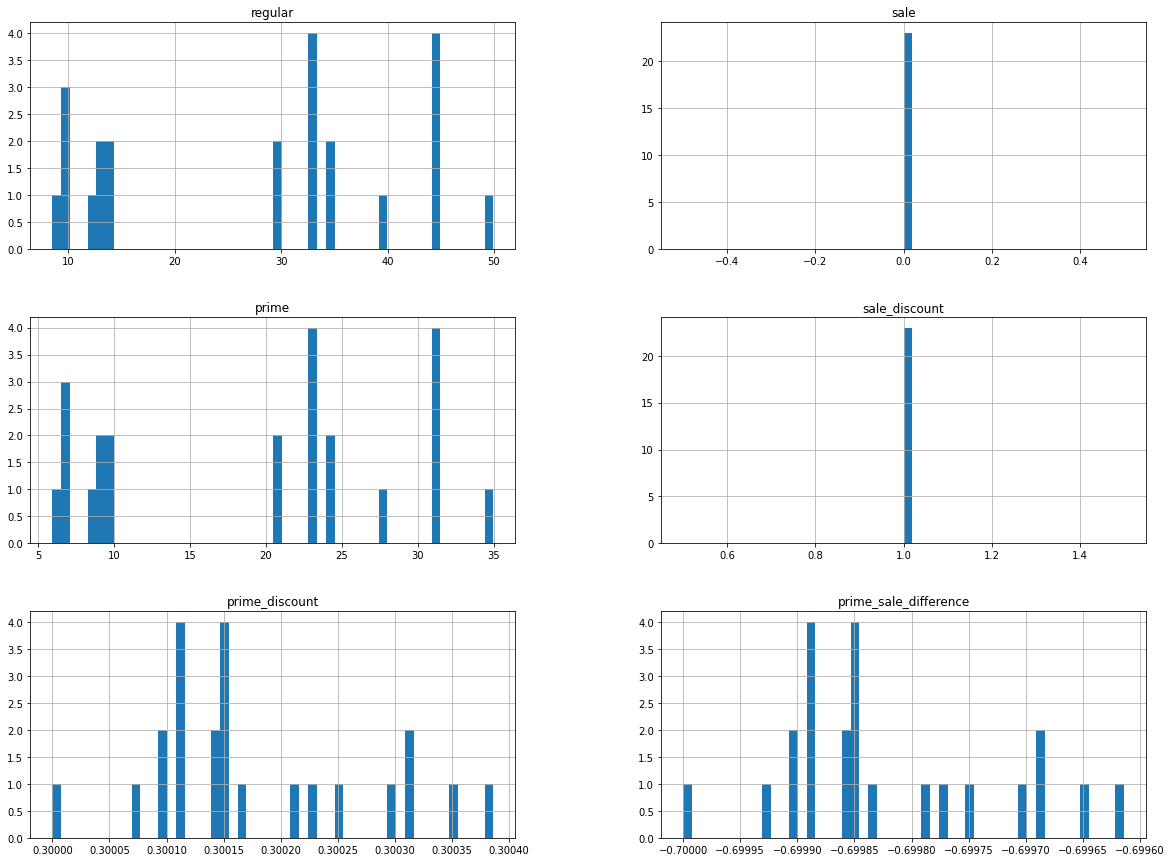

In [8]:
df[df['prime_sale_difference'] < 0].sort_values(by='prime_discount',ascending=False).hist(bins=50, figsize=(20,15)) 

### Histogram with all distributions where 'prime_sale_difference' is > 0 (Products on sale for regular customers and prime members (99% of the data)):
#### Showing all the items with a Regular, Sale, and Prime price
##### We can see that Prime members get an average discount of 28% off of on sale items, while non-members get an average of 20% off on sale items
##### This shows that on average, Prime members get their products discounted by 8% more that regular customers on average!

In [246]:
df[df['prime_sale_difference'] > 0].sort_values(by='prime_discount',ascending=False).describe().loc[['mean']]

,regular,sale,prime,sale_discount,prime_discount,prime_sale_difference
mean,8.215015,6.683366,6.014254,0.196992,0.277425,0.080433


array([[<AxesSubplot:title={'center':'regular'}>,
        <AxesSubplot:title={'center':'sale'}>],
       [<AxesSubplot:title={'center':'prime'}>,
        <AxesSubplot:title={'center':'sale_discount'}>],
       [<AxesSubplot:title={'center':'prime_discount'}>,
        <AxesSubplot:title={'center':'prime_sale_difference'}>]],
      dtype=object)

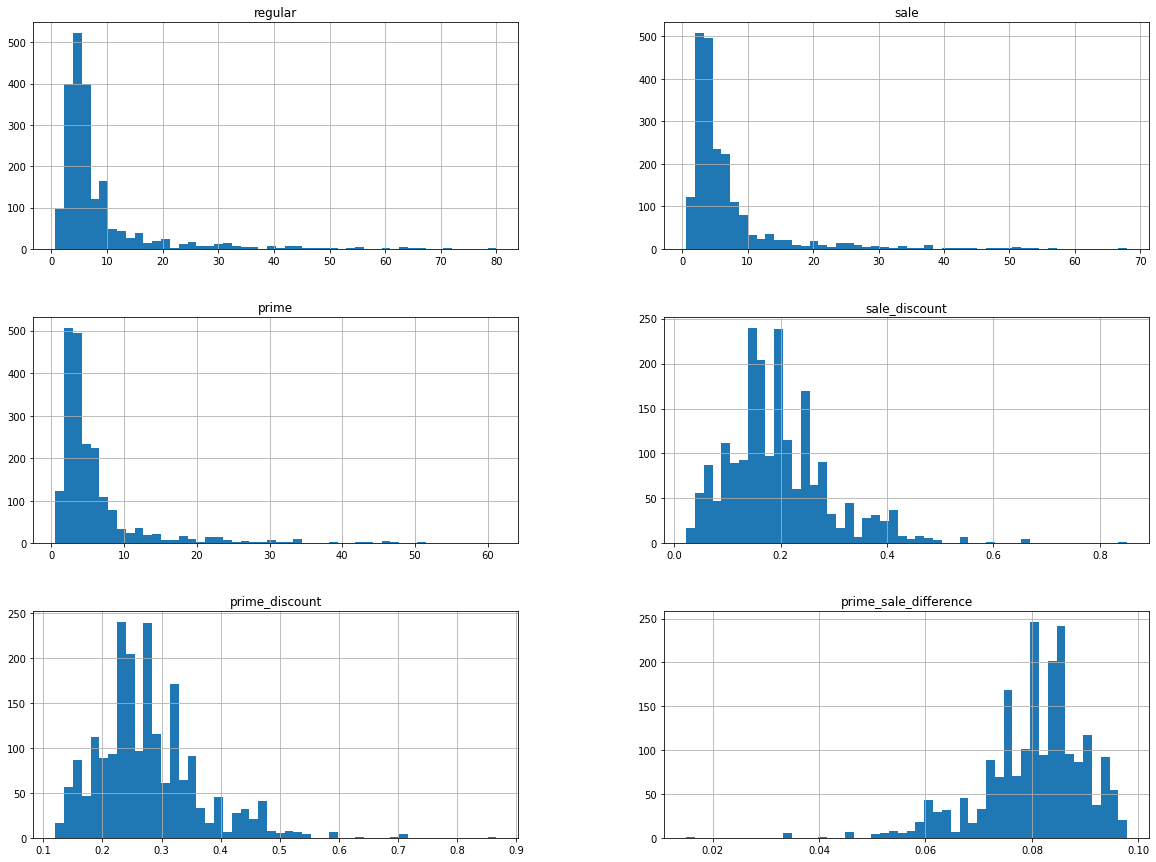

In [224]:
df[df['prime_sale_difference'] > 0].sort_values(by='prime_discount',ascending=False).hist(bins=50, figsize=(20,15)) 

## We can tell that most items that are featured on sale whether that be for non-prime members or prime members, are under $10
### Adding a legend of multiple companies is used for interactivity
#### If you know a favorite company of yours that sells a product at Whole Foods, try double clicking on them to see whether they have items on sale that meet your discounted needs!

In [280]:
import matplotlib as plt
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(df.sort_values(by='company'), x="prime_discount", y="regular", color="company", title="Products: Regular Price vs Prime Discount by Company", hover_data=['product', 'sale', 'prime'], width=1400, height=1000,
labels={
    "regular": "Regular Prices of Products",
    "prime_discount": "Prime Discount by Percent"
})
fig.show()

In [302]:
fig = px.scatter(df.sort_values(by='discount_bins'), x="prime_discount", y="regular", color="discount_bins", title="Products on sale: Regular Price vs Prime Discount by Prime Discount Range", hover_data=['product', 'sale', 'prime'], width=1400, height=1000,
labels={
    "regular": "Regular Prices of Products",
    "prime_discount": "Prime Discount by Percent",
    "discount_bins": "Prime Discount Ranges"
})
fig.show()

# Ian's Exploration


In [26]:
# Import data
df = pd.read_csv('Cleaned_WholeFoods_Sale_Data.CSV', index_col=0) # it is suggested that extensions are lowercase
df.reset_index(drop=True, inplace=True)

Since the data only has product names, there is a possibility to further breakdown the product names into specific words that actually represent the product themselves. Here we will use the SpaCy library to perform further EDA through Part-of-Speech tagging.

In [9]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [132]:
def explorer(x):
    # Explore part-of-speech tagging of the product names
    doc = nlp(x)
    for token in doc:
        yield token.text, token.pos_

In [136]:
[list(explorer(text)) for text in df['product']]

[[('Organic', 'PROPN'),
  ('Ground', 'PROPN'),
  ('Black', 'PROPN'),
  ('Pepper', 'PROPN'),
  (',', 'PUNCT'),
  ('4', 'NUM'),
  ('oz', 'NOUN')],
 [('Banana', 'PROPN'),
  ('And', 'CCONJ'),
  ('Maple', 'PROPN'),
  ('Brown', 'PROPN'),
  ('Sugar', 'PROPN'),
  ('Overnight', 'PROPN'),
  ('Oats', 'PROPN'),
  (',', 'PUNCT'),
  ('5.3', 'NUM'),
  ('oz', 'NOUN')],
 [('Overnight', 'PROPN'),
  ('Oats', 'PROPN'),
  ('With', 'ADP'),
  ('Ancient', 'PROPN'),
  ('Grains', 'PROPN'),
  ('Buleberries', 'PROPN'),
  (',', 'PUNCT'),
  ('5.3', 'NUM'),
  ('oz', 'NOUN')],
 [('Original', 'PROPN'),
  ('Overnight', 'PROPN'),
  ('Oats', 'PROPN'),
  (',', 'PUNCT'),
  ('5.3', 'NUM'),
  ('oz', 'NOUN')],
 [('Strawberry', 'PROPN'),
  ('Overnight', 'PROPN'),
  ('Oats', 'PROPN'),
  (',', 'PUNCT'),
  ('5.3', 'NUM'),
  ('oz', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Peanut', 'PROPN'),
  ('Butter', 'PROPN'),
  (',', 'PUNCT'),
  ('Creamy', 'PROPN'),
  (',', 'PUNCT'),
  ('28', 'NUM'),
  ('oz', 'NOUN')],
 [('Creamy', 'PROPN'),
  ('

  (')', 'PUNCT'),
  (',', 'PUNCT'),
  ('7.62', 'NUM'),
  ('oz', 'NOUN')],
 [('Peppermint', 'PROPN'),
  ('Essential', 'PROPN'),
  ('Oil', 'PROPN'),
  (',', 'PUNCT'),
  ('2', 'NUM'),
  ('fl', 'NOUN'),
  ('oz', 'NOUN')],
 [('Grain', 'PROPN'),
  ('Free', 'PROPN'),
  ('Sweet', 'PROPN'),
  ('Onion', 'PROPN'),
  ('Rings', 'PROPN'),
  (',', 'PUNCT'),
  ('3.5', 'NUM'),
  ('oz', 'NOUN')],
 [('Maple', 'PROPN'),
  ('Pecan', 'PROPN'),
  ('Oatmeal', 'PROPN'),
  (',', 'PUNCT'),
  ('2', 'NUM'),
  ('oz', 'NOUN'),
  (',', 'PUNCT'),
  ('1', 'NUM'),
  ('each', 'DET')],
 [('Summer', 'PROPN'),
  ('Berries', 'PROPN'),
  ('Boost', 'VERB'),
  ('Oatmeal', 'PROPN'),
  (',', 'PUNCT'),
  ('2', 'NUM'),
  ('oz', 'NOUN'),
  (',', 'PUNCT'),
  ('1', 'NUM'),
  ('each', 'DET')],
 [('Golden', 'PROPN'),
  ('Turmeric', 'PROPN'),
  ('Superfood', 'PROPN'),
  ('Oatmeal', 'PROPN'),
  (',', 'PUNCT'),
  ('1.76', 'NUM'),
  ('oz', 'NOUN')],
 [('Cacao', 'PROPN'),
  ('Superfood', 'PROPN'),
  ('Oatmeal', 'PROPN'),
  (',', 'PUNCT'),
  

  ('Rolled', 'PROPN'),
  ('Oats', 'PROPN'),
  (',', 'PUNCT'),
  ('3.25', 'NUM'),
  ('lb', 'NUM')],
 [('Nonfat', 'PROPN'),
  ('Dry', 'PROPN'),
  ('Milk', 'PROPN'),
  ('Powder', 'PROPN'),
  (',', 'PUNCT'),
  ('22', 'NUM'),
  ('oz', 'NOUN')],
 [('Organic', 'ADJ'),
  ('Tea', 'NOUN'),
  ('Tree', 'PROPN'),
  ('Liquid', 'PROPN'),
  ('Soap', 'PROPN'),
  (',', 'PUNCT'),
  ('16', 'NUM'),
  ('fl', 'NOUN'),
  ('oz', 'NOUN')],
 [('Peppermint', 'PROPN'),
  ('Soap', 'PROPN'),
  (',', 'PUNCT'),
  ('16', 'NUM'),
  ('fl', 'NOUN'),
  ('oz', 'NOUN')],
 [('Lavender', 'PROPN'),
  ('Soap', 'PROPN'),
  (',', 'PUNCT'),
  ('16', 'NUM'),
  ('fl', 'NOUN'),
  ('oz', 'NOUN')],
 [('Organic', 'ADJ'),
  ('Eucalyptus', 'PROPN'),
  ('Soap', 'PROPN'),
  (',', 'PUNCT'),
  ('16', 'NUM'),
  ('fl', 'NOUN'),
  ('oz', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Almond', 'PROPN'),
  ('Soap', 'PROPN'),
  (',', 'PUNCT'),
  ('16', 'NUM'),
  ('fl', 'NOUN'),
  ('oz', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Rose', 'PROPN'),
  ('Liquid', 'PRO

 [('Extra', 'PROPN'),
  ('Thick', 'PROPN'),
  ('Rolled', 'PROPN'),
  ('Oats', 'PROPN'),
  (',', 'PUNCT'),
  ('32', 'NUM'),
  ('oz', 'NOUN')],
 [('Original', 'PROPN'),
  ('Cheese', 'PROPN'),
  ('Puffs', 'PROPN'),
  ('(', 'PUNCT'),
  ('7', 'NUM'),
  ('Oz', 'NOUN'),
  (')', 'PUNCT')],
 [('Organic', 'PROPN'),
  ('Southwest', 'PROPN'),
  ('Taco', 'PROPN'),
  ('Simmer', 'PROPN'),
  ('Sauce', 'PROPN'),
  (',', 'PUNCT'),
  ('8', 'NUM'),
  ('oz', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Mild', 'PROPN'),
  ('Taco', 'PROPN'),
  ('Simmer', 'PROPN'),
  ('Sauce', 'PROPN'),
  (',', 'PUNCT'),
  ('8', 'NUM'),
  ('oz', 'NOUN')],
 [('Finely', 'ADV'),
  ('Ground', 'PROPN'),
  ('Hazelnut', 'PROPN'),
  ('Meal', 'PROPN'),
  (',', 'PUNCT'),
  ('14', 'NUM'),
  ('oz', 'NOUN')],
 [('Super', 'ADJ'),
  ('-', 'ADJ'),
  ('fine', 'ADJ'),
  ('Natural', 'PROPN'),
  ('Almond', 'PROPN'),
  ('Flour', 'PROPN'),
  (',', 'PUNCT'),
  ('16', 'NUM'),
  ('oz', 'NOUN')],
 [('Super', 'PROPN'),
  ('Fine', 'PROPN'),
  ('Almond', 'PROPN

  ('Sweet', 'PROPN'),
  ('Crème', 'PROPN'),
  (',', 'PUNCT'),
  ('16', 'NUM'),
  ('fluid', 'ADJ'),
  ('ounce', 'NOUN')],
 [('Instant', 'NOUN'),
  ('Brighten', 'VERB'),
  ('Facial', 'PROPN'),
  ('Mask', 'PROPN'),
  (',', 'PUNCT'),
  ('0.6', 'NUM'),
  ('fl', 'PROPN'),
  ('oz', 'NOUN'),
  ('e', 'NOUN')],
 [('Organic', 'ADJ'),
  ('American', 'ADJ'),
  ('Cheese', 'PROPN'),
  ('Slices', 'PROPN'),
  ('8', 'NUM'),
  ('oz', 'NOUN'),
  (',', 'PUNCT'),
  ('12', 'NUM'),
  ('slices', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Mozzarella', 'PROPN'),
  ('String', 'PROPN'),
  ('Cheese', 'PROPN'),
  (',', 'PUNCT'),
  ('6', 'NUM'),
  ('oz', 'NOUN'),
  ('.', 'PUNCT'),
  ('Pack', 'INTJ'),
  (',', 'PUNCT'),
  ('6', 'NUM'),
  ('Sticks', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Brown', 'PROPN'),
  ('Coconut', 'PROPN'),
  ('Sugar', 'PROPN'),
  (',', 'PUNCT'),
  ('1', 'NUM'),
  ('lb', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Wildberries', 'PROPN'),
  ('Whole', 'PROPN'),
  ('Milk', 'PROPN'),
  ('Kefir', 'PROPN'),
  (',', 

 [('Flax', 'PROPN'),
  ('Plus', 'CCONJ'),
  ('Instant', 'PROPN'),
  ('Oatmeal', 'PROPN'),
  (',', 'PUNCT'),
  ('14', 'NUM'),
  ('oz', 'NOUN')],
 [('Zero', 'NUM'),
  ('Calorie', 'NOUN'),
  ('Sweetener', 'PROPN'),
  ('40', 'NUM'),
  ('Count', 'PROPN'),
  (',', 'PUNCT'),
  ('1.12', 'NUM'),
  ('oz', 'NOUN')],
 [('Peanut', 'PROPN'),
  ('Butter', 'PROPN'),
  ('Puffins', 'PROPN'),
  ('Cereal', 'PROPN'),
  (',', 'PUNCT'),
  ('11', 'NUM'),
  ('oz', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Cookies', 'PROPN'),
  ('&', 'CCONJ'),
  ('Creme', 'PROPN'),
  ('Granola', 'PROPN'),
  ('Bars', 'PROPN'),
  (',', 'PUNCT'),
  ('0.85', 'NUM'),
  ('oz', 'NOUN')],
 [('Apple', 'PROPN'),
  ('Cinnamon', 'PROPN'),
  ('Instant', 'PROPN'),
  ('Oatmeal', 'PROPN'),
  (',', 'PUNCT'),
  ('14', 'NUM'),
  ('oz', 'NOUN')],
 [('Original', 'ADJ'),
  ('Instant', 'PROPN'),
  ('Oatmeal', 'PROPN'),
  (',', 'PUNCT'),
  ('14', 'NUM'),
  ('oz', 'NOUN')],
 [('Original', 'ADJ'),
  ('Puffins', 'PROPN'),
  ('Cereal', 'PROPN'),
  (',', 'PUNC

  ('Extra', 'PROPN'),
  ('Virgin', 'PROPN'),
  ('Olive', 'PROPN'),
  ('Oil', 'NOUN'),
  ('Roasted', 'PROPN'),
  ('Seaweed', 'NOUN'),
  (',', 'PUNCT'),
  ('0.35', 'NUM'),
  ('oz', 'NOUN')],
 [('Organic', 'ADJ'), ('Multicolor', 'PROPN'), ('Kale', 'PROPN')],
 [('Organic', 'PROPN'),
  ('Sweetened', 'PROPN'),
  ('Blood', 'PROPN'),
  ('Orange', 'PROPN'),
  ('Black', 'PROPN'),
  ('Tea', 'PROPN'),
  (',', 'PUNCT'),
  ('12', 'NUM'),
  ('fl', 'NUM'),
  ('oz', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Roasted', 'PROPN'),
  ('Premium', 'PROPN'),
  ('Seaweed', 'PROPN'),
  ('Snack', 'PROPN'),
  (',', 'PUNCT'),
  ('Avocado', 'PROPN'),
  ('Oil', 'PROPN'),
  (',', 'PUNCT'),
  ('.35', 'PUNCT'),
  ('Oz', 'NOUN'),
  (',', 'PUNCT'),
  ('0.32', 'NUM'),
  ('oz', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Sweetened', 'PROPN'),
  ('Raspberry', 'PROPN'),
  ('Black', 'PROPN'),
  ('Tea', 'PROPN'),
  (',', 'PUNCT'),
  ('12', 'NUM'),
  ('fluid', 'ADJ'),
  ('ounce', 'NOUN')],
 [('Orangic', 'PROPN'),
  ('Tea', 'PROPN'),
  ('H

  ('oz', 'NOUN')],
 [('Dry', 'PROPN'),
  ('Cat', 'PROPN'),
  ('Food', 'PROPN'),
  ('Chicken', 'PROPN'),
  ('&', 'CCONJ'),
  ('Brown', 'PROPN'),
  ('Rice', 'PROPN'),
  (',', 'PUNCT'),
  ('3', 'NUM'),
  ('lb', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Hemp', 'PROPN'),
  ('Powder', 'PROPN'),
  (',', 'PUNCT'),
  ('12', 'NUM'),
  ('oz', 'NOUN')],
 [('Calcium', 'NOUN'),
  ('Magnesium', 'PROPN'),
  ('With', 'ADP'),
  ('Vitamin', 'PROPN'),
  ('D', 'PROPN'),
  ('Complex', 'PROPN'),
  (',', 'PUNCT'),
  ('240', 'NUM'),
  ('capsules', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Chocolate', 'PROPN'),
  ('Plant', 'PROPN'),
  ('Protein', 'PROPN'),
  ('Powder', 'PROPN'),
  (',', 'PUNCT'),
  ('1.3', 'NUM'),
  ('lb', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Vanilla', 'PROPN'),
  ('Plant', 'PROPN'),
  ('Protein', 'PROPN'),
  ('Powder', 'PROPN'),
  (',', 'PUNCT'),
  ('1.2', 'NUM'),
  ('lb', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Blueberry', 'PROPN'),
  ('Muffin', 'PROPN'),
  ('Plant', 'PROPN'),
  ('Protein', 'PROPN'),


  ('Bar', 'PROPN'),
  (',', 'PUNCT'),
  ('Dark', 'PROPN'),
  ('Chocolate', 'PROPN'),
  ('Chip', 'PROPN'),
  ('Peanut', 'PROPN'),
  ('Butter', 'PROPN'),
  (',', 'PUNCT'),
  ('18.3', 'NUM'),
  ('oz', 'NOUN')],
 [('Original', 'ADJ'),
  ('Refrigerated', 'PROPN'),
  ('Protein', 'PROPN'),
  ('Bar', 'PROPN'),
  (',', 'PUNCT'),
  ('Peanut', 'PROPN'),
  ('Butter', 'PROPN')],
 [('Counter', 'PROPN'),
  ('Attack', 'PROPN'),
  ('Immune', 'PROPN'),
  ('Support', 'PROPN'),
  (',', 'PUNCT'),
  ('30', 'NUM'),
  ('tablets', 'NOUN')],
 [('Organic', 'PROPN'),
  ('Keto', 'PROPN'),
  ('Cacao', 'PROPN'),
  ('Powder', 'PROPN'),
  (',', 'PUNCT'),
  ('8', 'NUM'),
  ('oz', 'NOUN')],
 [('Whole', 'PROPN'),
  ('Milk', 'PROPN'),
  (',', 'PUNCT'),
  ('59', 'NUM'),
  ('fl', 'NOUN'),
  ('oz', 'NOUN')],
 [('Mushroom', 'NOUN'),
  ('Risotto', 'PROPN'),
  ('Veggie', 'PROPN'),
  ('Burgers', 'PROPN'),
  (',', 'PUNCT'),
  ('10', 'NUM'),
  ('oz', 'NOUN')],
 [('Sensible', 'ADJ'),
  ('Foods', 'PROPN'),
  ('Heirloom', 'PROPN'),
 

  (',', 'PUNCT'),
  ('11.3', 'NUM'),
  ('oz', 'NOUN')],
 [('The', 'DET'),
  ('Ultimate', 'PROPN'),
  ('Beefless', 'PROPN'),
  ('Burger', 'PROPN'),
  (',', 'PUNCT'),
  ('12', 'NUM'),
  ('oz', 'NOUN')],
 [('Free', 'PROPN'),
  ('Clear', 'PROPN'),
  ('Glass', 'PROPN'),
  ('Cleaner', 'PROPN'),
  (',', 'PUNCT'),
  ('23', 'NUM'),
  ('fl', 'NOUN'),
  ('oz', 'NOUN')],
 [('Mini', 'PROPN'),
  ('Crispy', 'PROPN'),
  ('Crabless', 'PROPN'),
  ('Cakes', 'PROPN'),
  (',', 'PUNCT'),
  ('8.8', 'NUM'),
  ('oz', 'NOUN')],
 [('Lightly', 'ADV'),
  ('Seasoned', 'ADJ'),
  ("Chick'n", 'PROPN'),
  ('Scallopini', 'PROPN'),
  (',', 'PUNCT'),
  ('10', 'NUM'),
  ('oz', 'NOUN')],
 [('Warrior', 'PROPN'),
  ('Bar', 'PROPN'),
  (',', 'PUNCT'),
  ('2', 'NUM'),
  ('oz', 'NOUN')],
 [('Seven', 'NUM'),
  ('Grain', 'PROPN'),
  ('Crispy', 'PROPN'),
  ('Tenders', 'PROPN'),
  (',', 'PUNCT'),
  ('9', 'NUM'),
  ('oz', 'NOUN')],
 [('Crispy', 'PROPN'),
  ('Golden', 'PROPN'),
  ("Chick'n", 'PROPN'),
  ('Nuggets', 'PROPN'),
  (',', '

In [137]:
spacy.explain('PROPN')

'proper noun'

It seems that the product items are mostly in "PROPN", or proper noun. We will create a parser to extract proper noun. Considering each item can have multiple proper noun, and some itme may not have any proper noun, we will find proper noun token with fewest heads as the top level proper noun, and if no proper noun is found, we will dedsinate `No PROPN`.

In [163]:
def parser(x):
    # Convert text into Doc object
    doc = nlp(x)
    dict_ = {}
    for token in doc:
        # If part-of-speech tag is not proper noun or noun, skip
        if token.pos_ not in ['PROPN', 'NOUN']: 
            continue
        else:
            # Collect length of dependencies
            text = token.text 
            dict_[text] = []
            source = token
            while source.head != source :
                dict_[text].append(source.text)
                source = source.head
    if len(dict_) == 0: 
        return 'No PROPN'
    # Retrieve text with lowest dependencies
    return sorted([(k, v) for k, v in dict_.items()], key=lambda x: len(x[1]))[0][0]

In [164]:
df['parsed_product'] = df['product'].apply(lambda x: parser(x))

It seems that our parser works only to a certain extend. For example, `Oat Malk Original, 32 fl oz` is not returning Oat Milk, but due to limited time, we will tackle the feature cleaning in the future.

In [166]:
df.sample(5)

,company,product,regular,sale,prime,sale_discount,prime_discount,prime_sale_difference,discount_bins,parsed_product
2007,Back to Nature,Rosemary & Olive Oil Harvest Whole Wheat Crack...,3.69,3.49,3.14,0.054201,0.149051,0.094851,0% to 25%,Cracker
1203,MALK Organics,"Oat Malk Original, 32 fl oz",5.99,4.99,4.49,0.166945,0.250417,0.083472,25% to 50%,Original
663,HYDRO FLASK,Kids Wide Mouth Straw Lid Boot Plumeria Bottle...,29.95,0.00,20.96,1.000000,0.300167,-0.699833,25% to 50%,Bottle
2050,BHU FOODS,"Keto Chocolate Chip Cookie Dough Bites, 5.29 oz",9.69,9.29,8.36,0.041280,0.137255,0.095975,0% to 25%,Bites
1072,JUST Egg,"Folded, 8 oz",4.29,3.50,3.15,0.184149,0.265734,0.081585,25% to 50%,oz


In [205]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [175]:
pca = PCA(n_components=2)

In [202]:
word_list = [nlp(x).vector for x in df['parsed_product']]
vecs_transformed = pca.fit_transform(np.vstack(word_list))

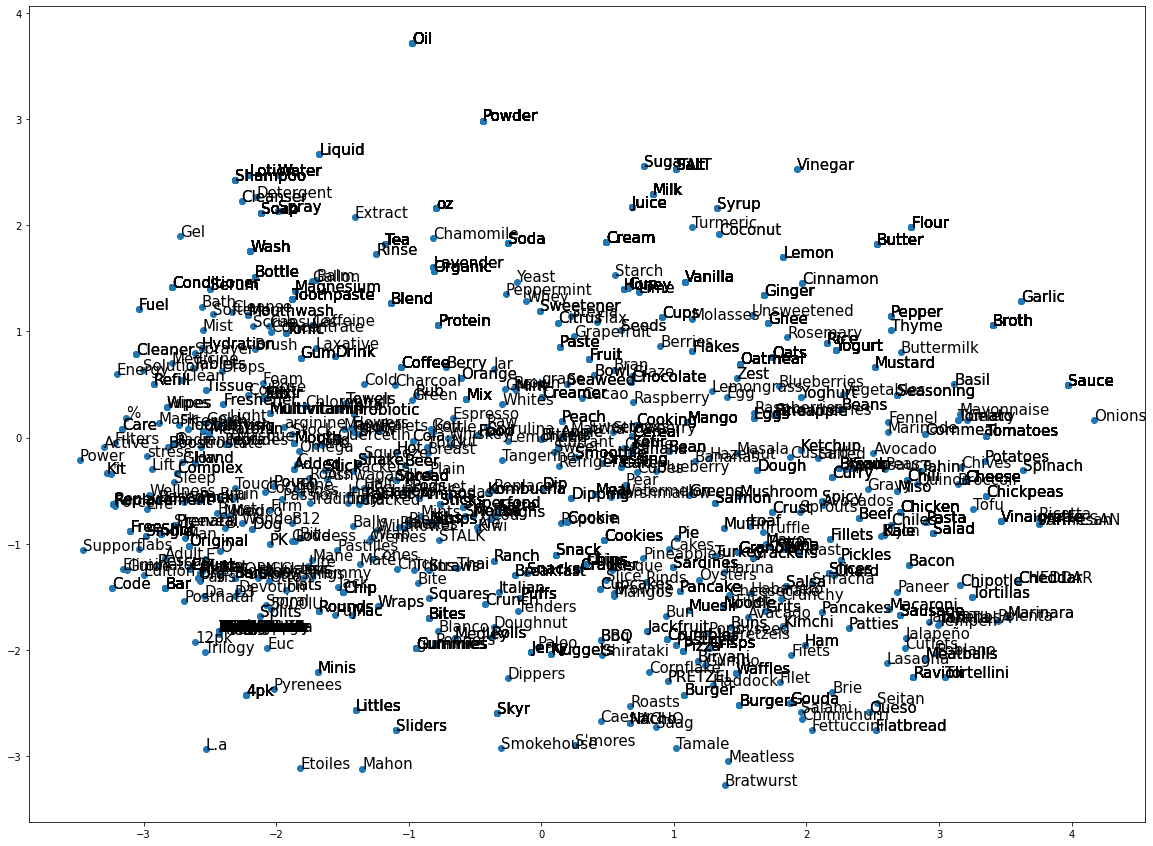

In [201]:
vecs_transformed = pca.fit_transform(np.vstack(word_list))
plt.figure(figsize=(20,15))
plt.scatter(vecs_transformed[:,0], vecs_transformed[:,1])
for word, coord in zip(df['parsed_product'], vecs_transformed):
    x,y = coord
    plt.text(x,y, word, size=15)
plt.show()